In [37]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys
import time

from collections import defaultdict

from blackjack import BlackjackEnv
import plotting

matplotlib.style.use('ggplot')

In [38]:
env = BlackjackEnv()


In [39]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    
    # this is the where you give a probability ε/n to every possible action
    # and probability of 1-ε + ε/n for the best one.
    def policy_fn(observation):
        probabilities = np.ones(nA) * epsilon / nA
        # for the best one we have a high probability
        best_action = np.argmax(Q[observation])
        probabilities[best_action] = 1 - epsilon + epsilon/nA
        return probabilities
        
    return policy_fn

In [40]:
l = [1,2,3,4,5]
fo = 2
for i, ll in enumerate(l[2:][::-1]):
    print(i, ll)
    
a = 3
b = 1 if a < 2 else 0

b

0 5
1 4
2 3


0

In [41]:
state = env.reset()
state

(12, 3, False)

In [94]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    # 1. Initialize policy, Q, Returns
    # 2. 
    # 2. compute the new policy you want to follow using 
    # make_epsilon_greedy_policy from your present Q function
    # 2. compute the new Q function based on a set of episodes 
    # sampled from the environment based on the new policy.
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    
    # Initialize policy, Q, Returns
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    policy = make_epsilon_greedy_policy(Q, epsilon, 2) #np.random.choice([0, 1])
    returns = defaultdict(float)
    returns_count = defaultdict(float)
    policy_count = 0
    returns_sum = defaultdict(float)

    
    for i_episode in range(1, num_episodes + 1):
        # Print out which episode we're on, useful for debugging.
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        ###############################################################################################
        # Generate an episode.
        # An episode is an array of (state, action, reward) tuples
        episode = []
        observation = env.reset()
        value = np.random.uniform(0,1)
        action = 0 if value < policy(observation)[0] else 1 # what action we chose depend on policy 
        # range is arbitrary, it should just not be shorter then any possible episode.
        for t in range(100):
            next_state, reward, done, _ = env.step(action)
            episode.append((observation, action, reward))
            if done:
                break
            observation = next_state
            value = np.random.uniform(0,1)
            action = 0 if value < policy(observation)[0] else 1 
        
        # Find all states the we've visited in this episode
        # We convert each state to a tuple so that we can use it as a dict key
        # states_in_episode = set([tuple(x[0]) for x in episode])
        
        # for state in states_in_episode: why like this
        for state in episode:   # state = (St, At, Rt)
            
            # Find the first occurance of the state-action pair in the episode
            first_occurence_idx = next(i for i,x in enumerate(episode) if x[0] == state[0])            
            # Calculate average return for this state over all sampled episodes
            G = sum([x[2]*(discount_factor**i) for i, x in enumerate(episode[first_occurence_idx:][::-1])])
            if state[:-1] not in returns: 
                returns[state[:-1]] = G
                returns_count[state[:-1]] = 1.0
            else:
                returns[state[:-1]] += G
                returns_count[state[:-1]] += 1.0
                
            Q[state[0]][state[1]] = returns[state[:-1]] / returns_count[state[:-1]]
           # print(Q[state])
        # update policy
            policy = make_epsilon_greedy_policy(Q, epsilon, 2) #np.argmax(Q[state[0]])
            policy_count +=1
    # Implement this!
    print('policy was updated: ')
    print(policy_count)
    return Q, policy

    

In [95]:
start = time.clock()

Q, policy = mc_control_epsilon_greedy(env, num_episodes=50000, epsilon=0.1)
Q2, policy2 = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)
end = time.clock()
print("\n",end - start,"s")

Episode 1000/50000.

/Users/Sofie/.conda/envs/languagetechnology/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


Episode 50000/50000.policy was updated: 
61055
Episode 500000/500000.policy was updated: 
622883

 85.94647600000002 s


/Users/Sofie/.conda/envs/languagetechnology/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """


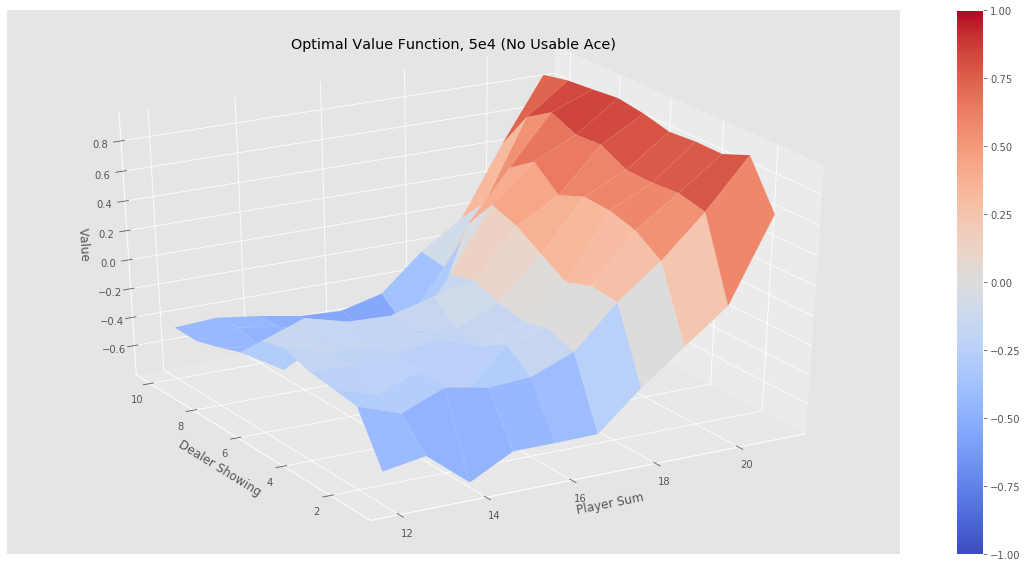

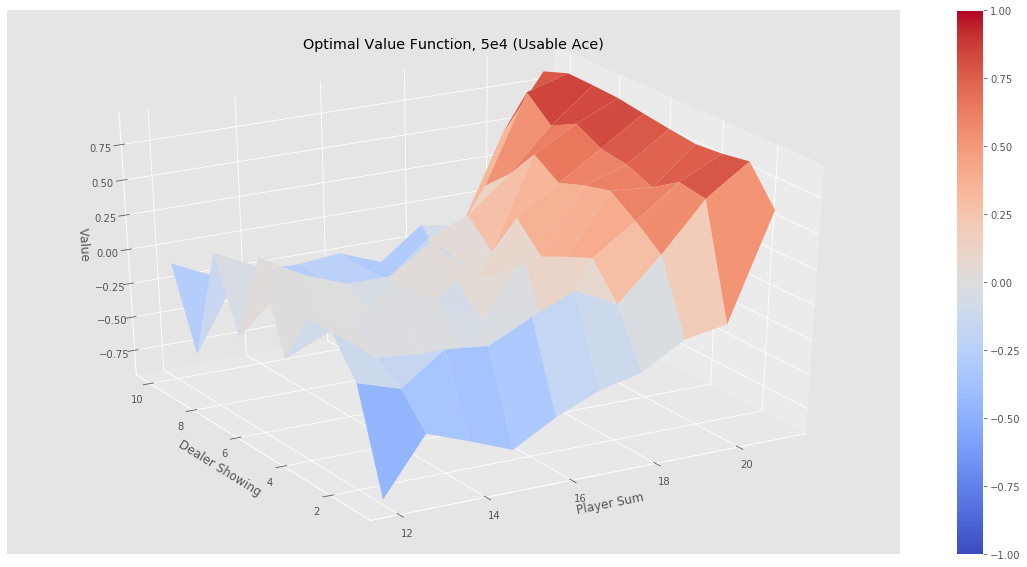

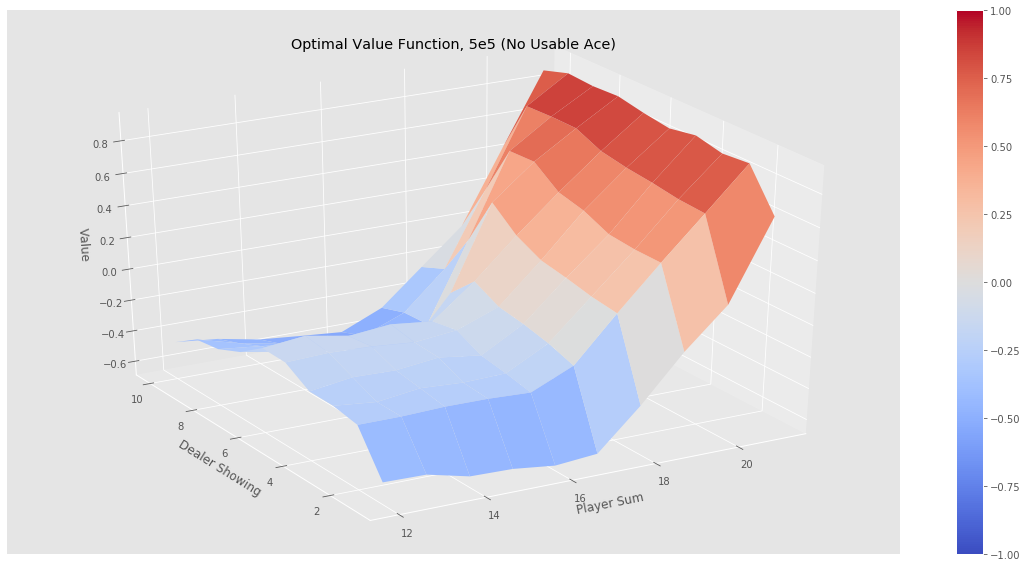

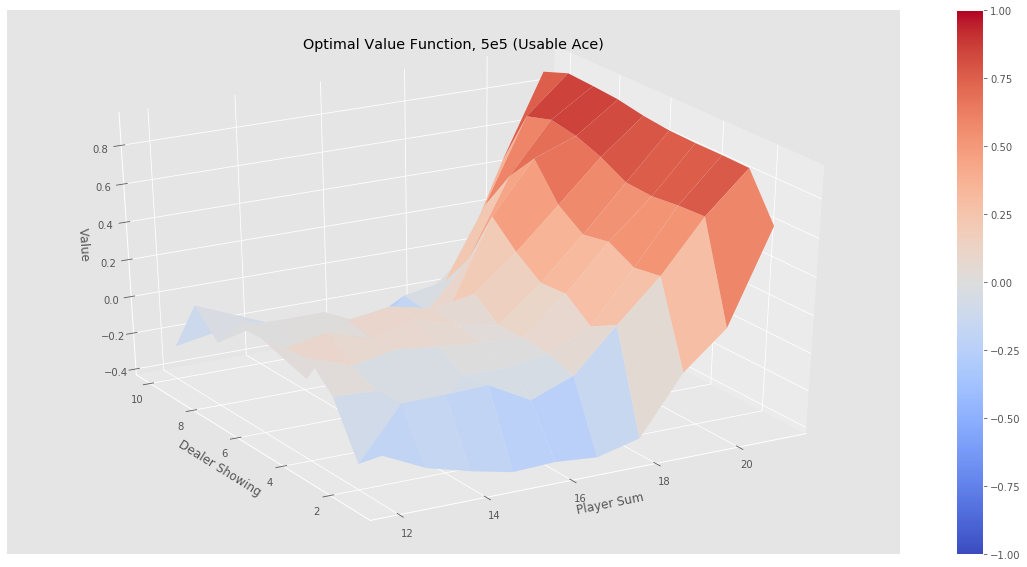

In [90]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function, 5e4")


V2 = defaultdict(float)
for state, actions in Q2.items():
    action_value = np.max(actions)
    V2[state] = action_value
plotting.plot_value_function(V2, title="Optimal Value Function, 5e5")
